#### REGRESSIONE NON LINEARE - SUPPORT VECTOR REGRESSION
 Regularization parameter C allows us to assign the weight to “slack,” telling the algorithm how much we care about the error. <br>
 Epsilon parameter ε determines the width of the tube around the estimated function (hyperplane). Points that fall inside this tube are considered as correct predictions and are not penalized by the algorithm 

In [1]:
from sklearn.svm import SVR 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from collections import Counter, defaultdict
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_curve, auc, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from pyod.models.abod import ABOD
from pyod.models.cof import COF
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import LabelEncoder

In [30]:
from sklearn.metrics import mean_absolute_error

In [15]:
def training_pulito_regressione(df_train_csv):
    selected = ['frame_count','kur', 'lag1_kur', 'mfcc_q05', 'mfcc_q95', 'mfcc_kur','sc_q50','stft_sum','kur_w1','lag1_kur_w1','mfcc_std_w1','mfcc_q99_w1','sc_std_w1','kur_w2','zc_sum_w2',
 'mfcc_sum_w2','mfcc_std_w2', 'mfcc_q01_w2' ,'mfcc_q05_w2', 'mfcc_q99_w2', 'mfcc_kur_w2', 'mfcc_skew_w2' ,'sc_q05_w2', 'sc_q25_w2', 'sc_q50_w2',
 'sc_q99_w2','sc_kur_w2','sc_skew_w2','stft_sum_w2','kur_w3','lag1_skew_w3','zc_sum_w3','mfcc_sum_w3','mfcc_mean_w3','mfcc_q01_w3','mfcc_q25_w3','mfcc_kur_w3','sc_std_w3',
 'sc_q01_w3','sc_q50_w3','sc_q95_w3','stft_sum_w3','stft_kur_w3','kur_w4','lag1_kur_w4','lag1_skew_w4','mfcc_max_w4','mfcc_q95_w4','mfcc_q99_w4','sc_sum_w4','sc_min_w4','sc_q50_w4',
 'sc_skew_w4','stft_sum_w4','stft_kur_w4']

    df_selected = df_train_csv[selected]
    emotion_train = df_train_csv['emotion']
    
    df_train_sel, df_test_sel, emotion_train_train, emotion_train_test = train_test_split(
        df_selected, emotion_train, test_size=0.3, random_state=0)
        
    ## outlier detection 
    # normalizzazione
    sc = StandardScaler()
    df_norm = sc.fit_transform(df_selected)  # normalizzato intero 

    # sc.fit(df_train_sel)
    # df_train_sel_norm=sc.transform(df_train_sel)  # normalizzato a pezzi
    # df_test_sel_norm=sc.transform(df_test_sel)

    # LOF
    clf=LocalOutlierFactor(n_neighbors=190)
    lof_outliers = clf.fit_predict(df_norm) 
    out_lof=np.where(lof_outliers==-1)

    # COF 
    cof_=COF(n_neighbors=20)
    cof_outliers = cof_.fit_predict(df_norm) 
    out_cof=np.where(cof_outliers==1)

    # ABOD
    clf = ABOD(0.02)  # contamination = 0.02
    clf.fit(df_norm)
    out_abod = np.where(clf.labels_ == 1)

    # ISOLATION FOREST 
    clf = IsolationForest(random_state=0 )
    clf.fit(df_selected)
    clf.predict(df_selected)
    if_outliers = clf.predict(df_selected)
    if_outliers #For each observation, tells whether or not (+1 or -1) it should be considered as an inlier according to the fitted model.
    #-1 sono outliers 
    out_if=np.where(if_outliers==-1)

    #qua trasformiamo tutto il lista per applicare la funzione counter
    out_lof_list = (out_lof[0]).tolist()
    out_cof_list = (out_cof[0]).tolist()
    out_if_list = (out_if[0]).tolist()
    out_abod_list = (out_abod[0]).tolist()

    outliers_lista = out_lof_list + out_cof_list + out_if_list + out_abod_list # lista di tutte le osservazioni outliers
    diz = Counter(outliers_lista) # contiamo quante volte si ripetono gli outliers nei 4 metodi 
    mega_outliers=[] # lista che riempiamo con gli outliers che si ripetono per almeno 3 volte 
    for el in diz:
        if diz[el]>=3:
            mega_outliers.append(el)

    selected_and_cat=['frame_count','modality', 'vocal_channel', 'emotion', 'emotional_intensity',
       'statement', 'repetition', 'actor', 'sex','filename','kur', 'lag1_kur', 'mfcc_q05', 'mfcc_q95', 'mfcc_kur', 'sc_q50',
    'sc_q75', 'stft_sum','kur_w1','lag1_kur_w1','mfcc_std_w1','mfcc_q99_w1','sc_std_w1','kur_w2','zc_sum_w2','mfcc_sum_w2','mfcc_std_w2','mfcc_q01_w2','mfcc_q05_w2',
    'mfcc_q99_w2','mfcc_kur_w2','mfcc_skew_w2','sc_q05_w2','sc_q25_w2','sc_q50_w2','sc_q99_w2','sc_kur_w2','sc_skew_w2','stft_sum_w2','kur_w3',
    'lag1_skew_w3','zc_sum_w3','mfcc_sum_w3','mfcc_mean_w3','mfcc_q01_w3','mfcc_q25_w3','mfcc_kur_w3','sc_std_w3','sc_min_w3','sc_q01_w3','sc_q50_w3','sc_q95_w3','stft_sum_w3',
    'stft_kur_w3','kur_w4','lag1_kur_w4','lag1_skew_w4','mfcc_max_w4','mfcc_q95_w4','mfcc_q99_w4','sc_sum_w4','sc_min_w4','sc_skew_w4','stft_sum_w4','stft_kur_w4']
    
    
    df_final_cat = df_train_csv[selected_and_cat]

    df_final = df_selected.drop(mega_outliers)   #rimozione dei mega outliers dal dataset 
    df_final_cat = df_final_cat.drop(mega_outliers)

    # df_final è numerico
    #df_final_cat è intero sia cat che num 
    return df_final, df_final_cat

In [14]:
# questa funzione ritorna il test set con le stesse colonne selezionate nel training set
def test_pulito_regressione(df):
    selected = ['frame_count','kur', 'lag1_kur', 'mfcc_q05', 'mfcc_q95', 'mfcc_kur','sc_q50','stft_sum','kur_w1','lag1_kur_w1','mfcc_std_w1','mfcc_q99_w1','sc_std_w1','kur_w2','zc_sum_w2',
   'mfcc_sum_w2','mfcc_std_w2', 'mfcc_q01_w2' ,'mfcc_q05_w2', 'mfcc_q99_w2', 'mfcc_kur_w2', 'mfcc_skew_w2' ,'sc_q05_w2', 'sc_q25_w2', 'sc_q50_w2',
   'sc_q99_w2','sc_kur_w2','sc_skew_w2','stft_sum_w2','kur_w3','lag1_skew_w3','zc_sum_w3','mfcc_sum_w3','mfcc_mean_w3','mfcc_q01_w3','mfcc_q25_w3','mfcc_kur_w3','sc_std_w3',
   'sc_q01_w3','sc_q50_w3','sc_q95_w3','stft_sum_w3','stft_kur_w3','kur_w4','lag1_kur_w4','lag1_skew_w4','mfcc_max_w4','mfcc_q95_w4','mfcc_q99_w4','sc_sum_w4','sc_min_w4','sc_q50_w4',
   'sc_skew_w4','stft_sum_w4','stft_kur_w4']
   
    selected_and_cat=['frame_count','modality', 'vocal_channel', 'emotion', 'emotional_intensity',
       'statement', 'repetition', 'actor', 'sex','filename','kur', 'lag1_kur', 'mfcc_q05', 'mfcc_q95', 'mfcc_kur', 'sc_q50',
    'sc_q75', 'stft_sum','kur_w1','lag1_kur_w1','mfcc_std_w1','mfcc_q99_w1','sc_std_w1','kur_w2','zc_sum_w2','mfcc_sum_w2','mfcc_std_w2','mfcc_q01_w2','mfcc_q05_w2',
    'mfcc_q99_w2','mfcc_kur_w2','mfcc_skew_w2','sc_q05_w2','sc_q25_w2','sc_q50_w2','sc_q99_w2','sc_kur_w2','sc_skew_w2','stft_sum_w2','kur_w3',
    'lag1_skew_w3','zc_sum_w3','mfcc_sum_w3','mfcc_mean_w3','mfcc_q01_w3','mfcc_q25_w3','mfcc_kur_w3','sc_std_w3','sc_min_w3','sc_q01_w3','sc_q50_w3','sc_q95_w3','stft_sum_w3',
    'stft_kur_w3','kur_w4','lag1_kur_w4','lag1_skew_w4','mfcc_max_w4','mfcc_q95_w4','mfcc_q99_w4','sc_sum_w4','sc_min_w4','sc_skew_w4','stft_sum_w4','stft_kur_w4']
    
    df_test_numerico = df[selected]
    df_test_num_cat = df[selected_and_cat]
    
    return df_test_numerico, df_test_num_cat

In [22]:
df_train_csv = pd.read_csv(r'C:\Users\Valeria\Documents\Università\DS\DM2\LAB\RavdessAudioOnlyFeatures_TRAIN.csv')
df_test_csv = pd.read_csv(r'C:\Users\Valeria\Documents\Università\DS\DM2\LAB\RavdessAudioOnlyFeatures_TEST.csv')


df_train_cat = training_pulito_regressione(df_train_csv)[1].drop('filename', axis = 1)  #droppo 'filename' perchè inutile, altrimenti mi esplode il numero delle colonne coded
df_test_cat = test_pulito_regressione(df_test_csv)[1].drop('filename', axis=1)


y_train = df_train_cat['frame_count'].values
y_test = df_test_cat['frame_count'].values


cat_features =['modality', 'vocal_channel', 'emotion', 'emotional_intensity',
       'statement', 'repetition', 'actor', 'sex']

X_train_cat = df_train_cat[cat_features]
X_test_cat = df_test_cat[cat_features]

# crea un unico DataFrame che combina le etichette di addestramento e di test per tutte le variabili categoriche
all_cat_labels = pd.concat([X_train_cat, X_test_cat], ignore_index=True)

# applica la codifica delle etichette alle etichette combinate
for feature in cat_features:
    le = LabelEncoder()
    all_cat_labels[feature] = le.fit_transform(all_cat_labels[feature])

# assegna le etichette codificate ai set di dati di addestramento e di test
X_train_cat = all_cat_labels.iloc[:len(X_train_cat)]
X_test_cat = all_cat_labels.iloc[len(X_train_cat):]

# continua con la tua analisi come prima
X_train_tmp = pd.concat([df_train_cat.drop(cat_features, axis=1), pd.DataFrame(X_train_cat)], axis=1)
X_train_enc = X_train_tmp.drop(['emotion','vocal_channel','modality', 'emotional_intensity',
 'statement', 'repetition', 'actor', 'sex'], axis = 1).values
X_test_tmp = pd.concat([df_test_cat.drop(cat_features, axis=1), pd.DataFrame(X_test_cat)], axis=1)
X_test_enc = X_test_tmp.drop(['emotion','vocal_channel','modality', 'emotional_intensity',
 'statement', 'repetition', 'actor', 'sex'], axis = 1).values

c:\Users\Valeria\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


In [23]:
# normalizzazione
# normalizzazione
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_train = scaler.fit_transform(y_train.reshape(-1, 1))
y_test = scaler.transform(y_test.reshape(-1, 1))


In [25]:
'''df_test_csv = pd.read_csv(r'C:\Users\Valeria\Documents\Università\DS\DM2\LAB\RavdessAudioOnlyFeatures_TEST.csv')
df_test = test_pulito_regressione(df_test_csv)[0]


X_train = df_train.drop('frame_count', axis = 1).values
y_train = df_train['frame_count'].values
X_test = df_test.drop('frame_count', axis = 1).values
y_test = df_test['frame_count'].values '''


# addestramento del modello
svr = SVR(kernel='rbf', C=10, epsilon=0.5) # a caso
svr.fit(X_train, y_train)
y_train_pred = svr.predict(X_train)
y_test_pred = svr.predict(X_test)

# valutazione delle performance sul training set
print('Performance sul training set:')
print('R²:', r2_score(y_train, y_train_pred))
print('MSE:', mean_squared_error(y_train, y_train_pred))

# valutazione delle performance sul test set
print('Performance sul test set:')
print('R²:', r2_score(y_test, y_test_pred))
print('MSE:', mean_squared_error(y_test, y_test_pred))

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 30-31: truncated \UXXXXXXXX escape (2525187667.py, line 8)

In [9]:
param_grid = {
    'kernel': ['rbf', 'linear', 'poly'],
    'C': [0.01, 1, 10, 10],
    'epsilon': [0.01, 0.1, 1, 10]
}

# cross-validation
grid_search = GridSearchCV(SVR(), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
print("Migliori parametri: ", grid_search.best_params_, grid_search.best_score_)  # Migliori parametri:  {'C': 1, 'epsilon': 0.1, 'kernel': 'linear'} -0.025110896625495916


c:\Users\Valeria\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Valeria\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Valeria\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Valeria\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1143: D

Migliori parametri:  {'C': 1, 'epsilon': 0.1, 'kernel': 'linear'} -0.025110896625495916


In [32]:
# addestramento del modello usando i parametri della grid search
svr = SVR(kernel='linear', C=1, epsilon=0.01) 
svr.fit(X_train, y_train)
y_train_pred = svr.predict(X_train)
y_test_pred = svr.predict(X_test)

# valutazione delle performance sul training set
print('Performance sul training set:')
print('R²:', r2_score(y_train, y_train_pred))
print('MSE:', mean_squared_error(y_train, y_train_pred))

# valutazione delle performance sul test set
print('Performance sul test set:')
print('R²:', r2_score(y_test, y_test_pred))
print('MSE:', mean_squared_error(y_test, y_test_pred))
print('MAE', mean_absolute_error(y_test, y_test_pred))

c:\Users\Valeria\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Performance sul training set:
R²: 0.9801496444406969
MSE: 0.01985035555930316
Performance sul test set:
R²: 0.9699154367044217
MSE: 0.030932579918907334
MAE 0.12744444884896594


In [33]:
y_baseline = np.full_like(y_test, np.mean(y_train)) # Calcolo della media della variabile target
mse_baseline = mean_squared_error(y_test, y_baseline)
print("MSE del modello baseline:", mse_baseline)
print('R² del modello baseline:', r2_score(y_test, y_baseline))
print("MAE del modello baseline:", mean_absolute_error(y_test, y_baseline))

MSE del modello baseline: 1.0919011400004155
R² del modello baseline: -0.06196667219398799
MAE del modello baseline: 0.8751817554513557


I risultati ottenuti indicano che il modello di regressione SVR si comporta molto bene sia sul set di addestramento che sul set di test. In particolare:

Il coefficiente di determinazione R², che varia da 0 a 1, misura quanto la varianza della variabile dipendente può essere spiegata dalle variabili indipendenti nel modello. In questo caso, sia il R² sul set di addestramento (0.980) che quello sul set di test (0.970) indicano che il modello è in grado di spiegare una percentuale molto elevata della varianza della variabile dipendente.

L'errore quadratico medio (MSE), che rappresenta la media dei quadrati degli errori tra i valori previsti dal modello e i valori effettivi della variabile dipendente, è molto basso sia sul set di addestramento (0.020) che sul set di test (0.031), il che indica che il modello è in grado di produrre previsioni molto precise sulla variabile target.

In generale, questi risultati suggeriscono che il modello di regressione SVR addestrato sul dataset Ravdess è in grado di produrre previsioni molto accurate sulla variabile target, e che tali previsioni generalizzano bene anche su nuovi dati.

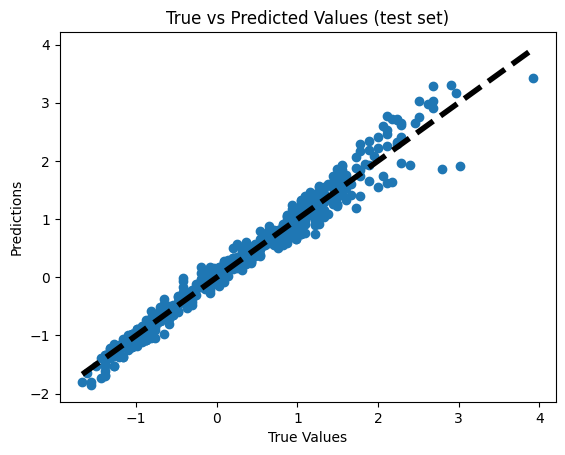

In [46]:
plt.scatter(y_test, y_test_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("True vs Predicted Values (test set)")
plt.show()